### Import libraries and define subject path

In [2]:
# This is our preprocessing script.
# We select one recording, clean stuff and then perform the ICA
# During this process, we save all bad components segments and channels

import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import mne
from autoreject import AutoReject, get_rejection_threshold

from data_analysis.functions_preprocessing import \
    (split_raws, mark_bads, save_bads, run_ica, save_ica,
     save_autoreject)
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

subject_dir = '/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/'
behav_dir = "/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"


%matplotlib widget
import matplotlib
matplotlib.get_backend()


Bad key "text.kerning_factor" on line 4 in
/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


'module://ipympl.backend_nbagg'

## Define the subject you want to clean

In [3]:
subj_pair = input("Please Type in, which subject pair you want to clean.\n"
                  "For the pilot study, possible choices are:\n"
                  "[202, 203, 204, 205, 206, 207, 208, 209, 211, 212]\n")

participant = input("\nPlease Type in, which subject pair you want to clean.\n"
                    "Type: 0 for the first participant and: 1 for the second.\n")

Please Type in, which subject pair you want to clean.
For the pilot study, possible choices are:
[202, 203, 204, 205, 206, 207, 208, 209, 211, 212]
204

Please Type in, which subject pair you want to clean.
Type: 0 for the first participant and: 1 for the second.
0


## Load and prepare the EEG recording

In [4]:
# define the subjects id and its path
subj_id = "sub-{0}_p-{1}".format(subj_pair, participant)
subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(subj_pair)
behav_path = op.join(behav_dir, "{0}.csv".format(subj_pair))

## overwrite it for the test
# TODO: This line should be removed for the actual cleaning
#subj_id = "test_2"

# load the data
combined_raw = mne.io.read_raw_fif(subs_path, preload=True)

# split the subjects and delete the raw file
raw = split_raws(combined_raw)[int(participant)]
del combined_raw

# set reference
raw.set_eeg_reference(["Cz"])

# set the EEG Montage. We use 64 chans from the standard 10-05 system.
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)

# filter
raw.filter(l_freq=0.1, h_freq=120)
raw.notch_filter(freqs=[50]) # bandstop the power grid

Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-204/eeg/sub-204_task-hyper_eeg.fif...


<ipython-input-4-b18a89411fb0>:11: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-204/eeg/sub-204_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3537048 =      0.000 ...  3454.148 secs
Ready.
Reading 0 ... 3537048  =      0.000 ...  3454.148 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 33793 samples (33.001 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR f

<Raw | sub-204_task-hyper_eeg.fif, 80 x 3537049 (3454.1 s), ~2.11 GB, data loaded>

## Define events and epoch the data

In [5]:
# do the behavioral analysis and get the epochs
behavioral_df = calculate_alpha(pd.read_csv(behav_path))
event_df = create_event_df(raw)
event_df = remove_ghost_triggers(event_df)
event_df = join_event_dfs(event_df, behavioral_df)

# get the first tap by looking at the first sample in each trial
min_idx = event_df.groupby(["trial"])["sample"].idxmin()
early_df = event_df[event_df.index.isin(min_idx)]
early_events = events_from_event_df(early_df)

# get the late taps by looking at the last sample - 1.5 seconds
max_idx = event_df.groupby(["trial"])["sample"].idxmax()
late_df = event_df[event_df.index.isin(max_idx)]
late_events = events_from_event_df(late_df)
late_events[:,0] -= int(raw.info["sfreq"] * 1.5)

# get the baseline events
base_events = mne.pick_events(mne.find_events(raw, shortest_event=1),
                          include=48)

# define the parameters for epoching
combined_events = np.vstack([base_events, early_events, late_events]) # , base_events
tmin = 0
tmax = 1.5

epochs = mne.Epochs(raw, combined_events, tmin=tmin, tmax=tmax,
                    baseline=None, preload=True)  #baseline=(0, 0)

6638 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]
6638 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]
900 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 900 events and 1537 original time points ...


<ipython-input-5-68ff3fcbfe88>:27: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, combined_events, tmin=tmin, tmax=tmax,


0 bad epochs dropped


## Run autoreject on the data

Running autoreject on ch_type=eeg








Estimated consensus=0.20 and n_interpolate=4
Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

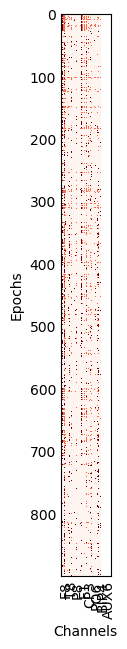

In [6]:
picks = mne.pick_types(epochs.info, eeg=True)

# define an autoreject object
ar = AutoReject(consensus=[0.1, 0.2, 0.3, 0.4, 0.5], thresh_method="random_search",
                picks=picks, verbose="tqdm_notebook") # [0.1, 0.2, 0.3, 0.4, 0.5], "bayesian_optimization"

# fit the epochs
ar.fit(epochs)

# get the rejection threshold for ICA
reject = get_rejection_threshold(epochs)

# plot it
reject_log = ar.get_reject_log(epochs)
reject_log.plot()

## Look at included and excluded epochs

In [7]:
scalings = dict(eeg=12e-5, eog=150e-6, misc=1e-3)
reject_log.plot_epochs(epochs, scalings=scalings)

print("Rejected {} out of {} epochs.".format(sum(reject_log.bad_epochs), len(epochs)))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Rejected 143 out of 900 epochs.


## Save the autoreject object

In [8]:
save_autoreject(ar, subj_id)

ValueError: /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_autoreject/sub-204_p-0-ar.hdf5 already exists. Please make overwrite=Trueif you want to overwrite this file

## Run (or load) the ICA and plot all components

In [9]:
# filter again for ICA
epochs.filter(l_freq=2, h_freq=None)


# run the ICA and save the marked components
picks = list(mne.pick_types(epochs.info, eeg=True, exclude=["Cz"]))
ica = run_ica(epochs[~reject_log.bad_epochs], subj_id, picks=picks, reject=reject,
              n_components=63, method="fastica")

Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 1691 samples (1.651 sec)



<ipython-input-9-33dafbe4b3c3>:2: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=2, h_freq=None)


Path to ICA file already exists.
Delete the respective ICA file (/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-204_p-0-ica.fif)
if you want to fit a new ICA.
 Loading existing ICA
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-204_p-0-ica.fif ...
Now restoring ICA solution ...
Ready.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Get ICA components based on their correlation with EOG

In [12]:
eog_name = "BIP1" if (participant == "0") else "BIP5"
eog_idx, eog_scores = ica.find_bads_eog(epochs, ch_name=eog_name)

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(epochs, picks=eog_idx)


Using channel BIP1 as EOG channel


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

    Using multitaper spectrum estimation with 7 DPSS windows
900 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

900 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

## Choose specific component properties to inspect

In [16]:
inp = input("Please type in which components you want to further "
            "inspect.\nE.G. 3, 4,15 for components 3, 4, and 15.\n")

inp = [int(n) for n in inp.split(",") if n != ""]

if len(inp) > 0:
    ica.plot_properties(epochs, picks=inp, reject=None)


Please type in which components you want to further inspect.
E.G. 3, 4,15 for components 3, 4, and 15.
61


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

    Using multitaper spectrum estimation with 7 DPSS windows
900 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


## Exclude specific ICA components

In [11]:
print("Excluded ICA components: ", ica.exclude)

inp = input("\nPlease type in which components you want to exclude.\n"
            "E.G. 2, 3,14 for components 2, 3, and 14.\n")

bad_comps = [int(comp) for comp in inp.split(",") if comp != ""]
bad_comps = [comp for comp in set(bad_comps) if comp not in ica.exclude]

ica.exclude.extend(bad_comps)
print("\nExcluded ICA components: ", ica.exclude)

Excluded ICA components:  [2, 12]

Please type in which components you want to exclude.
E.G. 2, 3,14 for components 2, 3, and 14.
2, 12

Excluded ICA components:  [2, 12]


## Save the ICA and its excluded components

In [13]:
inp = input("Do you really want to save the components?\n"
            "Enter 'save' or 's' to save the data. Else, "
            "changes will be discarded.\n")

if inp[0] == "s":
    save_ica(ica, subj_id)

Do you really want to save the components?
Enter 'save' or 's' to save the data. Else, changes will be discarded.
s
Writing ICA solution to /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-204_p-0-ica.fif...


### give everyone access to the new marked files you've created

In [12]:
!cd /net/store/nbp/projects/hyperscanning/study_project
!chown -hR $USER:nbp *; chmod -R 770 *



### Everything done. Thanks for cleaning :)